<img src='Quora-1.png'>

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import gc
import re
import time
import distance
import spacy
import sqlite3
import csv
import math

import datetime as dt
from tqdm import tqdm
from os import path
from PIL import Image

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import fuzz

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb

C:\Users\abc\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2>TASK-1:  Perfom Modeling on complete dataset with TF-IDF Features </h2>

In [3]:
# Load Basic Features
df_basic_feature = pd.read_csv("qora/df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [4]:
print("Columns : ",df_basic_feature.columns)
print("\nNumber of columns : ",len(df_basic_feature.columns))

df_basic_feature.head()

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

Number of columns :  17


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [5]:
# Load Advance Features
df_advance_features = pd.read_csv("qora/nlp_features_train.csv",encoding='latin-1')

In [6]:
print("Columns : ",df_advance_features.columns)
print("\nNumber of columns : ",len(df_advance_features.columns))

df_advance_features.head()

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  21


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


<br/>
Lets drop 'qid1', 'qid2','question1','question2','is_duplicate' columns and add both the dataframe 

In [7]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')

<br/>
Lets check for NaN values

In [8]:
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print (nan_rows)

            id                         question1  \
105780  105780    How can I develop android app?   
201841  201841  How can I create an Android app?   
363362  363362                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  ...  \
105780          2          2     30      0           6           1  ...   
201841          1          2     32      0           7           1  ...   
363362          1          1      0    123           1          21  ...   

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
105780      0.0           0.0            0.0           0.0       0.0   
201841      0.0           0.0            0.0 

<br/>
Found 3 such rows, we will remove these rows from the original dataset itself

In [9]:
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question1'].notnull()]
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question2'].notnull()]

In [10]:
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 30 columns]


In [11]:
df_basic_advance_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 30 columns):
id                      404287 non-null int64
question1               404287 non-null object
question2               404287 non-null object
is_duplicate            404287 non-null int64
freq_qid1               404287 non-null int64
freq_qid2               404287 non-null int64
q1len                   404287 non-null int64
q2len                   404287 non-null int64
q1_n_words              404287 non-null int64
q2_n_words              404287 non-null int64
word_Common             404287 non-null float64
word_Total              404287 non-null float64
word_share              404287 non-null float64
freq_q1+q2              404287 non-null int64
freq_q1-q2              404287 non-null int64
cwc_min                 404287 non-null float64
cwc_max                 404287 non-null float64
csc_min                 404287 non-null float64
csc_max                 404287 non-null float64

In [12]:
print("Columns : ",df_basic_advance_features.columns)
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head()

Columns :  Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  30


,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


<br/>
Lets separate the target feature

In [13]:
target = df_basic_advance_features['is_duplicate']

<br/>
Also drop the unnecessary id and is_duplicate column from feature dataset

In [14]:
df_basic_advance_features.drop(['id','is_duplicate'], axis=1, inplace=True)

In [15]:
print("Columns : ",df_basic_advance_features.columns)
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head()

Columns :  Index(['question1', 'question2', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  28


,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0.0,19.0,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2.0,20.0,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


# Split data into 70:30 

In [16]:
df_basic_advance_features=df_basic_advance_features[:100000]
target=target[:100000]

In [17]:
# spliting the data
X_train_tfidf,X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df_basic_advance_features, target, stratify=target, test_size=0.3)

In [18]:
print(X_train_tfidf.shape, y_train_tfidf.shape)
print(X_test_tfidf.shape, y_test_tfidf.shape)

(70000, 28) (70000,)
(30000, 28) (30000,)


# tfidf

In [19]:
# tfidf featurization of text data

tfidf_1 = TfidfVectorizer(lowercase=False)
tfidf_2 = TfidfVectorizer(lowercase=False)

ques_1_train = tfidf_1.fit_transform(X_train_tfidf['question1'].values)
ques_1_test = tfidf_1.transform(X_test_tfidf['question1'].values)

ques_2_train = tfidf_2.fit_transform(X_train_tfidf['question2'].values)
ques_2_test = tfidf_2.transform(X_test_tfidf['question2'].values)

In [20]:
# droping ques1' and 'ques2' features from test and train data

X_train_tfidf = X_train_tfidf.drop(['question1'], axis=1)
X_train_tfidf = X_train_tfidf.drop(['question2'], axis=1)

X_test_tfidf = X_test_tfidf.drop(['question2'], axis=1)
X_test_tfidf = X_test_tfidf.drop(['question1'], axis=1)

In [21]:
# stacking the tfidf features with advance created features
# looks like - manually created features + tfidf vectors for question 1 + tfidf vectors for question 2

tfidf_train = hstack((ques_1_train, ques_2_train)) 
X_train_tfidf = hstack((X_train_tfidf,tfidf_train))

tfidf_test = hstack((ques_1_test, ques_2_test))
X_test_tfidf = hstack((X_test_tfidf,tfidf_test))

In [22]:
print("Number of data points in train data :",X_train_tfidf.shape)
print("Number of data points in test data :",X_test_tfidf.shape)

Number of data points in train data : (70000, 71782)
Number of data points in test data : (30000, 71782)


In [23]:
from sklearn.preprocessing import normalize
X_train_tfidf = normalize(X_train_tfidf)
X_test_tfidf = normalize(X_test_tfidf)

In [25]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train_tfidf)
train_len = len(y_train_tfidf)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test_tfidf)
test_len = len(y_test_tfidf)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


<br/>
<br/>
<h2>  Apply ML Models</h2>

<h3>  Random Model</h3>

Log loss on Test Data using Random Model 0.8867206840359001


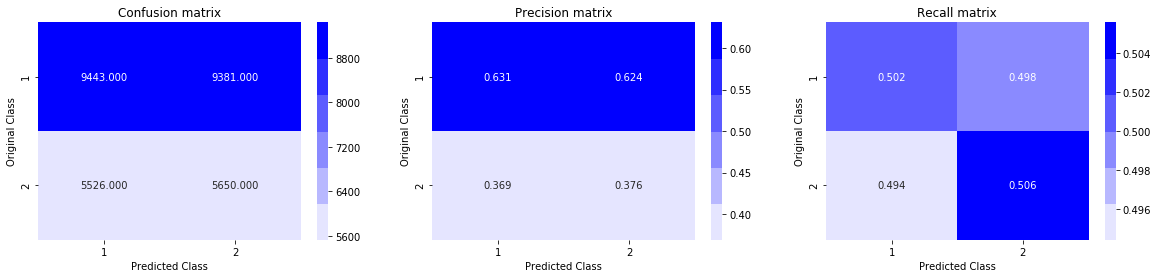

In [27]:
predicted_y = np.zeros((len(y_test_tfidf),2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test_tfidf, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test_tfidf, predicted_y)

<br/>
<br/>
<h3>  Logistic Regression with hyperparameter tuning</h3>

For values of alpha =  1e-14 The log loss is: 0.4435429416025203
For values of alpha =  1e-13 The log loss is: 0.441459708459612
For values of alpha =  1e-12 The log loss is: 0.4393099224354064
For values of alpha =  1e-11 The log loss is: 0.4428524518820062
For values of alpha =  1e-10 The log loss is: 0.4417261210147111
For values of alpha =  1e-09 The log loss is: 0.44222144747057635
For values of alpha =  1e-08 The log loss is: 0.44102379564265565
For values of alpha =  1e-07 The log loss is: 0.4430220327726353
For values of alpha =  1e-06 The log loss is: 0.4388671230092853
For values of alpha =  1e-05 The log loss is: 0.45378478824432966
For values of alpha =  0.0001 The log loss is: 0.49620924159303215
For values of alpha =  0.001 The log loss is: 0.5403597263678784
For values of alpha =  0.01 The log loss is: 0.5722123213174316
For values of alpha =  0.1 The log loss is: 0.5848483986245179
For values of alpha =  1 The log loss is: 0.6044214793772655
For values of alpha =  10 Th

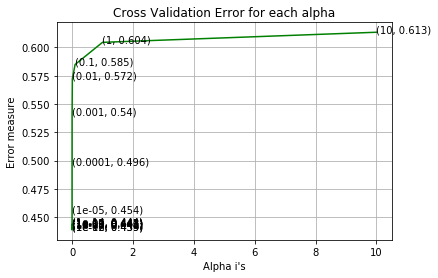

For values of best alpha =  1e-06 The train log loss is: 0.43952234841240106
For values of best alpha =  1e-06 The test log loss is: 0.4388671230092853
Total number of data points : 30000


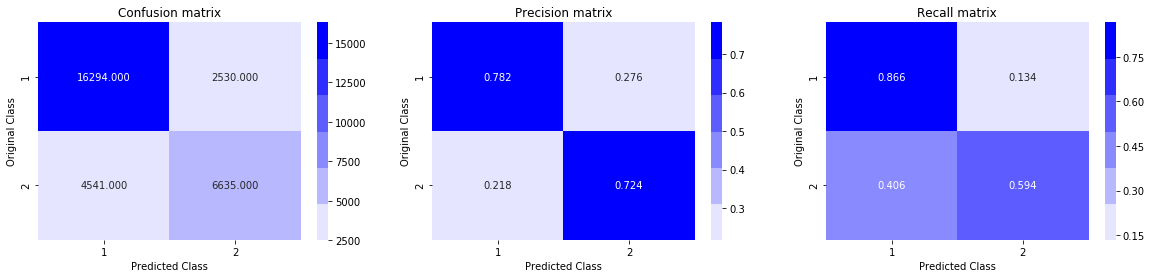

In [28]:
alpha = [10 ** x for x in range(-14, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_tfidf, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_tfidf, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

<br/>
<br/>
<h3>  Linear SVM with hyperparameter tuning </h3>

For values of alpha =  1e-14 The log loss is: 0.44195005955547617
For values of alpha =  1e-13 The log loss is: 0.4417964886786868
For values of alpha =  1e-12 The log loss is: 0.4390771244831543
For values of alpha =  1e-11 The log loss is: 0.43938927275860307
For values of alpha =  1e-10 The log loss is: 0.44180322753212814
For values of alpha =  1e-09 The log loss is: 0.4421005065718539
For values of alpha =  1e-08 The log loss is: 0.4424549288845417
For values of alpha =  1e-07 The log loss is: 0.4441213428923719
For values of alpha =  1e-06 The log loss is: 0.4424885807320436
For values of alpha =  1e-05 The log loss is: 0.4482441152544804
For values of alpha =  0.0001 The log loss is: 0.46014862283902075
For values of alpha =  0.001 The log loss is: 0.5394029591372813
For values of alpha =  0.01 The log loss is: 0.569946249897882
For values of alpha =  0.1 The log loss is: 0.5917674286248469
For values of alpha =  1 The log loss is: 0.6602902102099691
For values of alpha =  10 Th

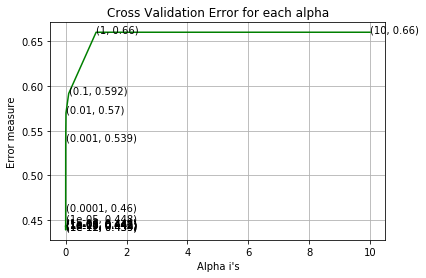

For values of best alpha =  1e-12 The train log loss is: 0.43942457580986416
For values of best alpha =  1e-12 The test log loss is: 0.4390771244831543
Total number of data points : 30000


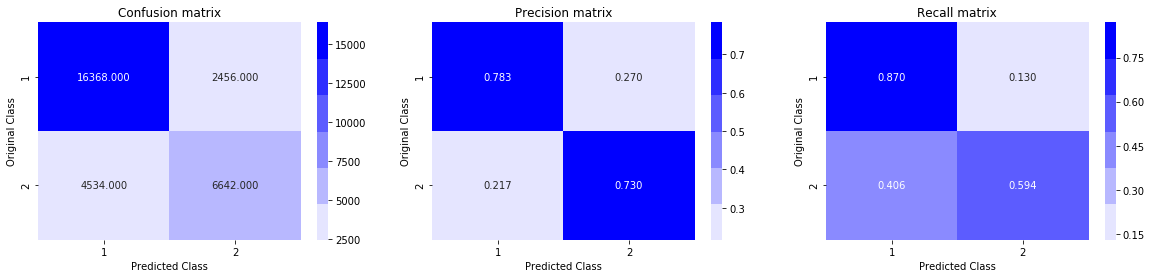

In [29]:
alpha = [10 ** x for x in range(-14, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_tfidf, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_tfidf, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

# conclusion

* We applied Tf-idf for question1 and question2 and then stacked the sparse matrices with the the features calculated before    hand.
* converted the final sparse matrix to Compressed-Sparse-Row(csr) format and then randomly split the sparse matrix 100k rows for easy computations.
* split the data into Train and Test using train_test_split.
* we applied Logistic Regression and Linear-SVM on the sparse matrix and found the Log-Loss of both the models and found that Linear-SVM performs slightly better than Logistic Regression.

In [31]:
# Please compare all your models using Prettytable library
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Table for Random Forest
name=['linear svm','log regg']

test_log_loss = [0.439,0.438]

numbering_rf = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering_rf)
ptable.add_column("Name",name)
ptable.add_column("Test log loss",test_log_loss)

print('TABLE linear svm && log regg by using tidf vec')
# Printing the Table
print(ptable)
print("\n\n")


TABLE linear svm && log regg by using tidf vec
+-------+------------+---------------+
| S.NO. |    Name    | Test log loss |
+-------+------------+---------------+
|   1   | linear svm |     0.439     |
|   2   |  log regg  |     0.438     |
+-------+------------+---------------+



